<a href="https://colab.research.google.com/github/MittalNeha/retinopathy-kaggle/blob/master/Retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

In [0]:
def get_kaggle_data():
  os.environ['KAGGLE_USERNAME'] = "mittalneha"
  os.environ['KAGGLE_KEY'] = "59ec3f992f5fb4b510bebd8dea889381"
  
  !kaggle competitions download -c aptos2019-blindness-detection
  !kaggle datasets download -d keras/vgg16
  
  !mkdir kaggle-data
  !mv sample_submission.csv kaggle-data/
  !mv test.csv kaggle-data/
  !mv train.csv kaggle-data/
  !unzip test_images.zip -d kaggle-data/test_images
  !unzip train_images.zip -d kaggle-data/train_images
  
  !unzip vgg16.zip -d kaggle-data/vgg16/
  

In [0]:
data_dir = "kaggle-data"
get_kaggle_data()

100% 8.01G/8.01G [01:09<00:00, 158MB/s]
100% 8.01G/8.01G [01:09<00:00, 124MB/s]
 99% 1.49G/1.50G [00:11<00:00, 107MB/s]
100% 1.50G/1.50G [00:11<00:00, 137MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 56.9MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 25.2MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 29.0MB/s]
 97% 528M/542M [00:06<00:00, 107MB/s] 
100% 542M/542M [00:06<00:00, 84.5MB/s]
Archive:  test_images.zip
  inflating: kaggle-data/test_images/270a532df702.png  
  inflating: kaggle-data/test_images/86fd5df366b2.png  
  inflating: kaggle-data/test_images/72dd7ca97f55.png  
  inflating: kaggle-data/test_images/ec8f3ec97245.png  
  inflating: kaggle-data/test_images/b3db392f5ee8.png  
  inflating: kaggle-data/test_images/c71728f9535b.png  
  inflating: kaggle-data/test_images/c7c003cdaaba.png  
  inflating: kaggle-data/test_images/67b614d32bcc.png  
  inflating: kaggle-data/test_images/e982c6b5b726.png  
  inflating: 

In [0]:

# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


Using TensorFlow backend.


In [0]:
# print(os.listdir(data_dir))

In [0]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

seed = 111

In [0]:

data_dir = Path(data_dir)

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train_images'

# Path to validation directory
#val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test_images'

In [0]:
train_data = pd.read_csv(data_dir/'train.csv')
train_data.head()
train_data.columns = ['id_code', 'label']
train_data.columns

Index(['id_code', 'label'], dtype='object')

In [0]:
train_data.shape

(3662, 2)

In [0]:
Y = train_data['label']

In [0]:
Y.shape

(3662,)

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_data, test_size=0.1)

valid_data = []
valid_labels = []

for idx, row in val.iterrows():
    path = str(train_dir) + '/' + row['id_code']+'.png'
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(int(row['label']), num_classes=5)
    valid_data.append(img)
    valid_labels.append(label)
    
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (367, 224, 224, 3)
Total number of labels: (367, 5)


In [0]:
train_data = train
train_data.shape

(3295, 2)

In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
def data_gen(data, batch_size, mode='train'):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,5), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = str(train_dir) + '/' + data.iloc[idx]['id_code']+'.png'
            
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=5)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = orig_img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
#             if label==0 and count < batch_size-2:
#             if label!=0 and label!=2 and count < batch_size-3:
            if label!=0 and count < batch_size-3 and mode=='train':
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=3            
            else:
                count+=1

            if count>=batch_size-1:
                break
            
        i+=1
        
        yield batch_data, batch_labels
            
        if i>=steps:
#             print(count)
#             for kk in range(0,count):
#                 plt.figure()
#                 plt.imshow(batch_data[kk])
#                 plt.title(str(kk))
#             return
            i=0

In [0]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model =  build_model()
model.summary()

W0720 03:13:28.790310 140286745614208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 03:13:28.801504 140286745614208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 03:13:28.837487 140286745614208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0720 03:13:28.937192 140286745614208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 03:13:28.938805 140286745614208 deprecation_wrap

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [0]:

# Open the VGG16 weight file
f = h5py.File('kaggle-data/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()


In [0]:
# model.save_weights('init_weights.h5')

In [0]:
!mkdir kaggle-data/model/

mkdir: cannot create directory ‘kaggle-data/model/’: File exists


In [0]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=3)
# filepath="kaggle-data/model/weights-improvement-{epoch:02d}.hdf5"
filepath="kaggle-data/model/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
chkpt = ModelCheckpoint(filepath=filepath, save_best_only=True, save_weights_only=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

W0720 03:13:41.623332 140286745614208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



**k-fold crossvalidation**

In [0]:
import gc

In [0]:
# del model

gc.collect()

0

In [0]:
kfold_history = []

In [0]:
# K.clear_session()

In [0]:
from sklearn.model_selection import StratifiedKFold

batch_size = 16
nb_epochs = 20

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# kappa_metrics = Metrics()
i = 0
init_epoch = 0

for train_idx, val_idx in kfold.split(train_data, Y):
  print(train_idx)
  train_data_gen = data_gen(data=train_data.iloc[train_idx], batch_size=batch_size)
  val_data_gen = data_gen(data=train_data.iloc[val_idx], batch_size=batch_size, mode='validation')
  
  nb_train_steps = len(train_data.iloc[train_idx]) //batch_size
  nb_val_steps = len(train_data.iloc[val_idx]) //batch_size
  
#   model =  build_model()
  model.load_weights('init_weights.h5')
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
  
  r = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=val_data_gen,
                                validation_steps=nb_val_steps, callbacks=[es, chkpt], 
                                class_weight={0:0.4040466, 1:1.9439528, 2:0.74128234, 3:3.89940828, 4:2.46816479})
  kfold_history.append(r)
#   del model
  gc.collect()
#   init_epoch += len(history.history['loss'])
#   print("init_epoch = {}".format(init_epoch))
  i+=1
  

In [0]:
kfold_history.update(history.history)

In [0]:
kfold_history

{'acc': [0.12957317073170732, 0.21859756097560976],
 'loss': [1.9451652576283711, 1.7566672159404289],
 'val_acc': [0.08967391304347826, 0.12228260869565218],
 'val_loss': [2.0030137404151587, 1.6014452706212583]}

In [0]:
history.history['acc']

[0.8862257281553398,
 0.8995752427184466,
 0.8980582524271845,
 0.8956310679611651,
 0.9001820388349514,
 0.9035194174757282,
 0.9089805825242718,
 0.9135315533980582]

In [0]:
def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings
  
def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.

    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.

    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.

    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    print(min_rating.shape)
    print(max_rating.shape)
    conf_mat = confusion_matrix(rater_a, rater_b)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = np.argmax(y_val, axis=-1)
#         y_val = y_val.astype(int).sum(axis=1) - 1
        print(y_val.shape)
        
        y_pred = self.model.predict(X_val)
        y_pred = np.argmax(y_pred, axis=-1)
        print(y_pred.shape)
#         print(y_pred[0])
#         y_pred = y_pred.astype(int).sum(axis=1) - 1
        
#         print(y_pred.shape)
        _val_kappa = quadratic_weighted_kappa(y_val, y_pred)

#         _val_kappa = cohen_kappa_score(
#             y_val,
#             y_pred, 
#             weights='quadratic'
#         )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('kaggle-data/model/model.h5')

        return

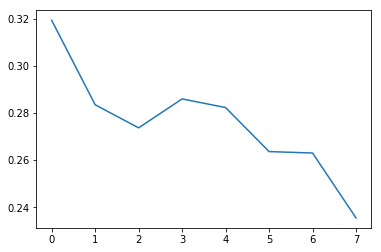

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')

In [0]:
len(history.history['loss'])


1

In [0]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 205 and 367


In [0]:
valid_labels.shape

(367, 5)

In [0]:
# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced', np.unique(orig_train_labels), orig_train_labels)

In [0]:
# kappa_metrics = Metrics()
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt])


Epoch 1/20
205/205 [==============================] - 145s 708ms/step - loss: 1.3701 - acc: 0.3646 - val_loss: 1.4048 - val_acc: 0.2997
Epoch 2/20
205/205 [==============================] - 139s 677ms/step - loss: 1.2953 - acc: 0.4564 - val_loss: 1.4254 - val_acc: 0.4469
Epoch 3/20
205/205 [==============================] - 135s 660ms/step - loss: 1.1218 - acc: 0.5878 - val_loss: 0.9404 - val_acc: 0.6785
Epoch 4/20
205/205 [==============================] - 134s 653ms/step - loss: 1.0064 - acc: 0.6558 - val_loss: 0.8886 - val_acc: 0.7003
Epoch 5/20
205/205 [==============================] - 141s 686ms/step - loss: 0.9921 - acc: 0.6372 - val_loss: 0.7740 - val_acc: 0.7302
Epoch 6/20
205/205 [==============================] - 137s 669ms/step - loss: 0.9813 - acc: 0.6351 - val_loss: 0.7998 - val_acc: 0.6894
Epoch 7/20
205/205 [==============================] - 135s 659ms/step - loss: 0.9621 - acc: 0.6479 - val_loss: 0.7934 - val_acc: 0.7193
Epoch 8/20
205/205 [============================

In [0]:
len(history.history['loss'])

4

In [0]:
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig(args["plot"])

In [0]:
eval_data, val_data = train_test_split(train_data, test_size=0.8)



In [0]:
#Evaluate with train data itself
eval_img = []
eval_labels = []

for idx, row in eval_data.iterrows():
    path = str(train_dir) + '/' + row['id_code']+'.png'
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(int(row['label']), num_classes=5)
    eval_img.append(img)
    eval_labels.append(label)
    
eval_img = np.array(eval_img)
eval_labels = np.array(eval_labels)

# Original labels
orig_eval_labels = np.argmax(eval_labels, axis=-1)

In [0]:
preds = model.predict(eval_img, batch_size=16)
preds = np.argmax(preds, axis=-1)



<Figure size 432x288 with 0 Axes>

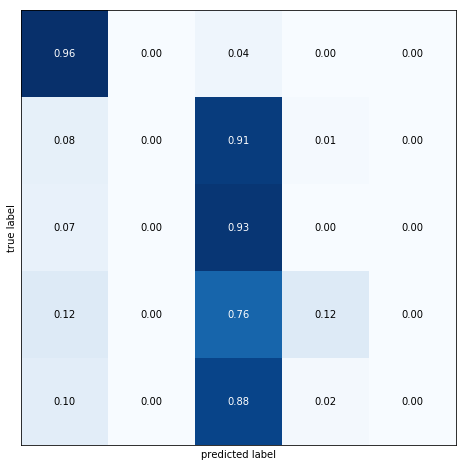

In [0]:
cm  = confusion_matrix(orig_eval_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
#plt.xticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
#plt.yticks(range(5), ['0', '1', '2', '3', '4'], fontsize=16)
plt.show()


In [0]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt], initial_epoch=9,
                              class_weight={0:0.4040466, 1:1.9439528, 2:0.74128234, 3:3.89940828, 4:2.46816479})

Epoch 10/20
205/205 [==============================] - 147s 715ms/step - loss: 1.5912 - acc: 0.5893 - val_loss: 0.8761 - val_acc: 0.7003
Epoch 11/20
205/205 [==============================] - 140s 682ms/step - loss: 1.6299 - acc: 0.5290 - val_loss: 0.9207 - val_acc: 0.5777
Epoch 12/20
205/205 [==============================] - 137s 669ms/step - loss: 1.6018 - acc: 0.5003 - val_loss: 0.9920 - val_acc: 0.6185
Epoch 13/20
205/205 [==============================] - 139s 677ms/step - loss: 1.5095 - acc: 0.5354 - val_loss: 0.8807 - val_acc: 0.6431


<Figure size 432x288 with 0 Axes>

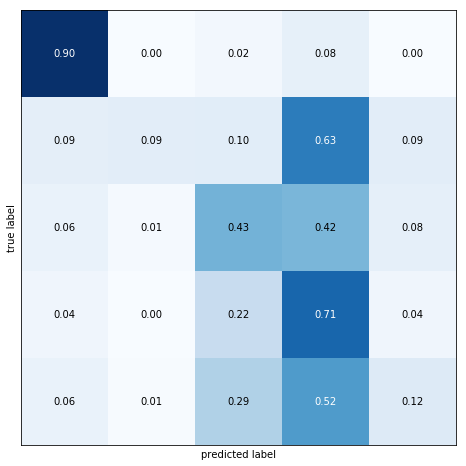

In [0]:
preds = model.predict(eval_img, batch_size=16)
preds = np.argmax(preds, axis=-1)
cm  = confusion_matrix(orig_eval_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
plt.show()

In [0]:
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt], initial_epoch=13,
                              class_weight={0:0.4040466, 1:1.9439528, 2:0.74128234, 3:3.89940828, 4:2.46816479})

Epoch 14/20
205/205 [==============================] - 145s 708ms/step - loss: 1.5723 - acc: 0.5220 - val_loss: 1.0259 - val_acc: 0.6240
Epoch 15/20
205/205 [==============================] - 135s 657ms/step - loss: 1.4866 - acc: 0.5396 - val_loss: 0.8706 - val_acc: 0.6294
Epoch 16/20
205/205 [==============================] - 136s 661ms/step - loss: 1.4834 - acc: 0.5488 - val_loss: 0.8874 - val_acc: 0.6730
Epoch 17/20
205/205 [==============================] - 144s 703ms/step - loss: 1.4283 - acc: 0.5716 - val_loss: 1.0510 - val_acc: 0.5831
Epoch 18/20
205/205 [==============================] - 146s 711ms/step - loss: 1.4248 - acc: 0.5530 - val_loss: 0.9042 - val_acc: 0.6594


<Figure size 432x288 with 0 Axes>

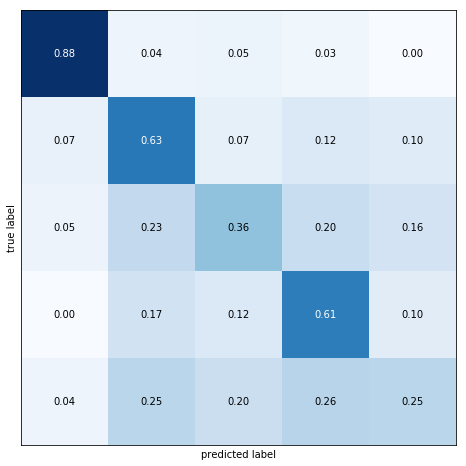

In [0]:
preds = model.predict(eval_img, batch_size=16)
preds = np.argmax(preds, axis=-1)
cm  = confusion_matrix(orig_eval_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
plt.show()

In [0]:
nb_epochs=50

In [0]:
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt], initial_epoch=20,
                              class_weight={0:0.4040466, 1:1.9439528, 2:0.74128234, 3:3.89940828, 4:2.46816479})

Epoch 21/50
205/205 [==============================] - 149s 724ms/step - loss: 1.3760 - acc: 0.5543 - val_loss: 0.8474 - val_acc: 0.6866
Epoch 22/50
205/205 [==============================] - 142s 694ms/step - loss: 1.3229 - acc: 0.5994 - val_loss: 0.8682 - val_acc: 0.6322
Epoch 23/50
205/205 [==============================] - 137s 667ms/step - loss: 1.2066 - acc: 0.6073 - val_loss: 0.8099 - val_acc: 0.6567
Epoch 24/50
205/205 [==============================] - 136s 661ms/step - loss: 1.3432 - acc: 0.5860 - val_loss: 0.7886 - val_acc: 0.6512
Epoch 25/50
205/205 [==============================] - 137s 669ms/step - loss: 1.2500 - acc: 0.6073 - val_loss: 0.7712 - val_acc: 0.7003
Epoch 26/50
205/205 [==============================] - 138s 675ms/step - loss: 1.1645 - acc: 0.6192 - val_loss: 0.7842 - val_acc: 0.6785
Epoch 27/50
205/205 [==============================] - 136s 661ms/step - loss: 1.2284 - acc: 0.6250 - val_loss: 0.7365 - val_acc: 0.7003
Epoch 28/50
205/205 [====================

<Figure size 432x288 with 0 Axes>

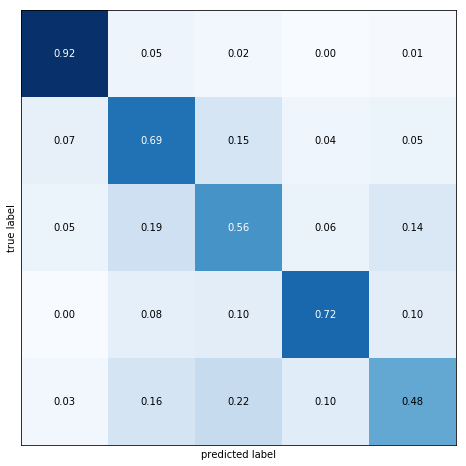

In [0]:
preds = model.predict(eval_img, batch_size=16)
preds = np.argmax(preds, axis=-1)
cm  = confusion_matrix(orig_eval_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
plt.show()

In [0]:
# model.load_weights('kaggle-data/model/model_acc84.h5')

In [0]:
model1 =  build_model()
model1.load_weights('kaggle-data/model/weights-improvement-27-0.70.hdf5')

W0720 05:05:38.888994 140286745614208 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


<Figure size 432x288 with 0 Axes>

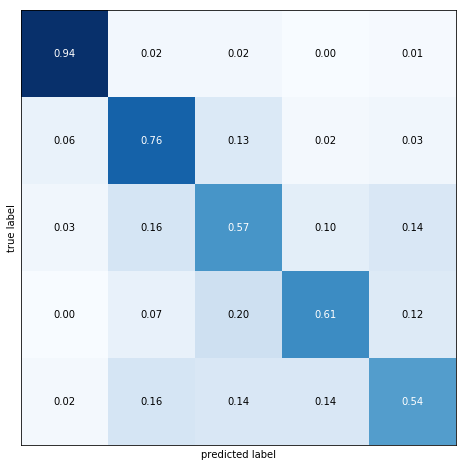

In [0]:
preds = model.predict(eval_img, batch_size=16)
preds = np.argmax(preds, axis=-1)
cm  = confusion_matrix(orig_eval_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
plt.show()